In [20]:
import numpy as np
import random
import math

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from numba import njit

In [27]:
#creating the mathematical heaviside function used in the stat simulation
@njit
def heaviside(x1):
    if x1 < 0:
        return 0
    return 1

#summing the number of residues in the chain as a proxy for energy
@njit
def mySum(arr):
    tot=0
    for i in arr:
        tot+=i
    return tot

In [28]:

#creating an array of given length to store state of a peptide chain
#The first portion of peptides will be in coil(0) state and last portion will be helix(1)
@njit
def createChain(length, helicity):
    
    chain = np.zeros(length)
    if helicity != 0:
        for i in range(len(chain)):
            if i/helicity<length:
                chain[i]=1    
    return chain

#Helixes and coil residues are randomly placed along chain
def createRandChain(length, **kwargs):
    
    helicity = kwargs.get('helicity', 0.5)
    chain = np.zeros(length)
    
    for i in range(0,length):
        if random.random()<helicity:
            chain[i] = 1
    return chain

#printing the state of the chain where a coil is "-" and helix is "+"
@njit
def display(system):
    for i in system:
        if i > 0.5:
            print("+", end = '')
        else:
            print("-", end = '')
    print("\n")


#function to find the First passage time (FPT) of a given peptide chain called 'spin', with J, H & limit parameters
@njit
def FPT(spin, J, H, limit):
    
    FPT = 0

    # iterating until helicity is achieved or limit is reached 
    for j in range(limit*len(spin)):
        

        #selecting random residue and applying circular chain rules for adjacent residues
        x = random.randint(0,len(spin)-1)
        xLeft = x-1
        xRight = x+1
        
        k=0
        #Left terminal residue rates
        if xLeft<0:
            if spin[x]==0 and spin[xRight]==0:
                k=math.exp(-H)**(-heaviside(-H))
            elif spin[x]==0 and spin[xRight]==1:
                k=math.exp(-H-J)**(-heaviside(-J-H))
            elif spin[x]==1 and spin[xRight]==0:
                k=math.exp(-H)**(heaviside(H))
            elif spin[x]==1 and spin[xRight]==1:
                k=math.exp(-H-J)**(heaviside(J+H))
            S = spin[xRight]
        
        #Right terminal residue rates
        if xRight==len(spin): 
            if spin[x]==0 and spin[xLeft]==0:
                k=math.exp(-H)**(-heaviside(-H))
            elif spin[x]==0 and spin[xLeft]==1:
                k=math.exp(-H-J)**(-heaviside(-J-H))
            elif spin[x]==1 and spin[xLeft]==0:
                k=math.exp(-H)**(heaviside(H))
            elif spin[x]==1 and spin[xLeft]==1:
                k=math.exp(-H-J)**(-heaviside(-J-H))
            S = spin[xLeft]
        
        #interior residue rates
        #mapping particular conformation to 3-bit reference number, eg Helix-Coil-Helix = 101 
        #finding k-value(without v factor) for the given number.
        if k==0:
            S = spin[xLeft] + spin[xRight]
            ref = 4*spin[xLeft] + 2*spin[x] + spin[xRight]
        
            if ref==0: k=math.exp(-H)**(-heaviside(-H))
            if ref==1: k=math.exp(-H-J)**(-heaviside(-J-H))
            if ref==2: k=math.exp(-H)**(heaviside(H))
            if ref==3: k=math.exp(-H-J)**(heaviside(+J+H))
            if ref==4: k=math.exp(-H-J)**(-heaviside(-J-H))
            if ref==5: k=math.exp(-H-2*J)**(-heaviside(-2*J-H))
            if ref==6: k=math.exp(-H-J)**(heaviside(J+H))
            if ref==7: k=math.exp(-H-J*2)**(heaviside(2*J+H))
        
        if k==0: print("Error in k not found!")
        
        
        #change in energy if the spin were to flip  
        deltaE = 2*(J*S+H)*(spin[x]-0.5)
        
        #probability to flip the spin
        p = 1/(1+math.exp(deltaE))
        
        #flipping spin with the given probability
        if (random.random()<p):
            spin[x] = 1-spin[x]
        # Time ~ 1/(vk); v=10^9
        FPT += 1/(p*k*10**9)
            
        #return FPT when critical alignment is met
        #helicity = mySum(spin)/len(spin)
        helicity = np.mean(spin)
        tolerance = 0.001
        critAlignment = 1
        if (helicity>=critAlignment-tolerance):
            #print("Within limit!, J = %.f, H = %.f"%(J, H))
            return FPT*10**-9,helicity
            break
    
    #print("Exceeded limit")
    return FPT*10**-9,helicity



@njit  
def FPT_dist(spin,J, H, limit, numReps):

    
    reps = np.zeros(numReps)
    helicities = np.zeros(numReps)
    
    for j in range(len(reps)):
        reps[j], helicities[j] = FPT(spin.copy(), J, H, limit)
    return(reps, helicities)



@njit
def MFPT(spin, J, H, limit, numReps):
    
    myFPTDist, myHelicities = FPT_dist(spin, J,H, limit, numReps)
    
    return np.mean(myFPTDist),np.mean(myHelicities)


@njit
def getSurf(J_ax, H_ax, limit, numReps, chainLength, helicity):
    
    Z = np.zeros((len(J_ax), len(H_ax)))
    surfHelicity = np.zeros((len(J_ax), len(H_ax)))

    
    #myChain = createRandChain(chainLength, helicity=helicity)
    myChain = createChain(chainLength, helicity)
    
    for x in range(len(J_ax)):
        for y in range(len(H_ax)):
            time, meanHelicity = MFPT(myChain.copy(), J=J_ax[x], H=H_ax[y], limit=limit, numReps=numReps)
            Z[x][y] = time
            surfHelicity[x][y] = meanHelicity
            #print(time, end = ' ')
            #print("%.f percent complete!"%((x*len(H_ax)+y)/(len(H_ax)*len(J_ax))*100))
    print("Surface Complete!\n\n")
    return Z, surfHelicity



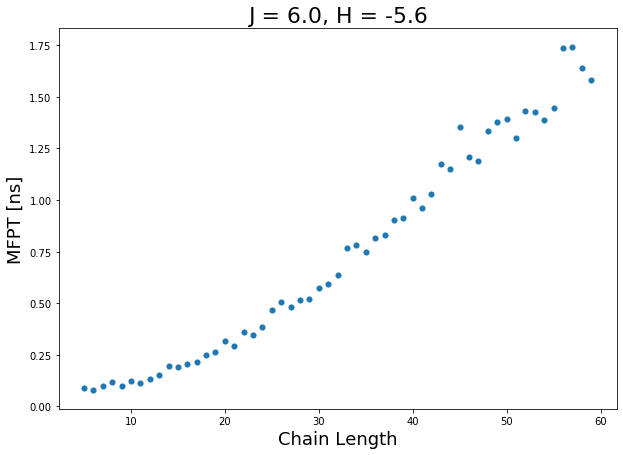

In [29]:
critAlignment = 0.99
J = 6
H = -5.6

#chain lengths we want to study
minLength = 5
maxLength = 60

reps = 120

chainLength = np.arange(minLength,maxLength)

#creating list for mean first passage times
mfpts = np.zeros(len(chainLength))

#creating list for standard errors of the mean
sem = np.zeros(len(chainLength))

for i in range(len(chainLength)):
    myChain=createChain(int(chainLength[i]),helicity = 0.2)
    
    myFPTs = FPT_dist(myChain,limit=3750, J=J, H=H, numReps=reps)
    
    newMean = np.mean(myFPTs[0])
    #calculate standard error of the mean 
    newSem = np.std(myFPTs, ddof=1) / np.sqrt(np.size(myFPTs))
    
    mfpts[i] = newMean
    sem[i] = newSem



#plotting the results of how MFPTs are effected by chainlength
plt.figure(figsize=(10,7))
plt.scatter(chainLength, mfpts*10**9, linewidth = 0.1)
#plt.errorbar(chainLength, mfpts, yerr=sem,fmt='-o', markersize = 0, linewidth = 1)

plt.xlabel("Chain Length", fontsize = 18)
plt.ylabel("MFPT [ns]", fontsize = 18)
plt.title("J = %.1f, H = %.1f" %(J,H), fontsize = 22)
#plt.savefig('MFPTs_on_chain_length.png', dpi = 500)
plt.show()

μ =0.5000, σ = 0.5000


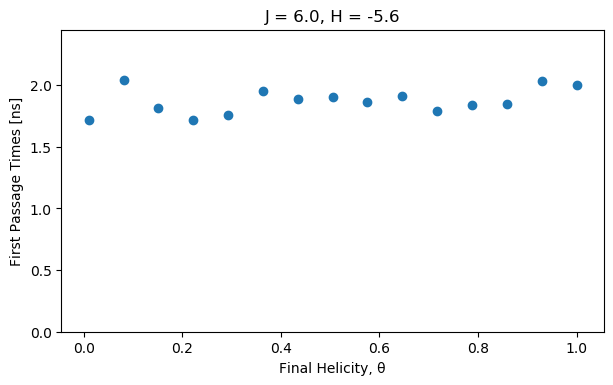

In [7]:

#Analysis of impact on final chain configuration(helicity)
#from an initial all-coil peptide

critAlignmentSamples = np.linspace(0.01, 1, 15)
MFPTs = np.zeros(len(critAlignmentSamples))

myChain = createChain(60, helicity = 0.0)

limit =500
reps = 150

for i in range(len(critAlignmentSamples)):
    
    critAlignment = critAlignmentSamples[i]
    MFPTs[i] = MFPT(myChain, J, H, limit, reps)[0] #we take the [0] element for MFPT because [1] is helicity
    

    
#Showing the lack of dependance on final/passage condition
plt.figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(critAlignmentSamples, MFPTs*10**9)
plt.ylim(0,1.2*np.max(MFPTs*10**9))


plt.title("J = %.1f, H = %.1f" %(J,H))
plt.xlabel("Final Helicity, θ")
plt.ylabel("First Passage Times [ns]")


#plt.savefig("First_Passage_Time_Distribution.png", dpi = 500) 

print("\u03BC =%.4f, \u03C3 = %.4f" %(np.mean(myFPTs),np.std(myFPTs)))


In [8]:
#plotting Fig2:
critAlignment = 1


J_ax = np.linspace(6,9,13)
H_ax = np.linspace(-9,-6,13)

X, Y = np.meshgrid(J_ax, H_ax)

limit=1200
numReps =3
chainLength = 21
helicity = 0

Z60, H60 = getSurf(J_ax, H_ax, limit, numReps, chainLength, helicity)



Surface Complete!




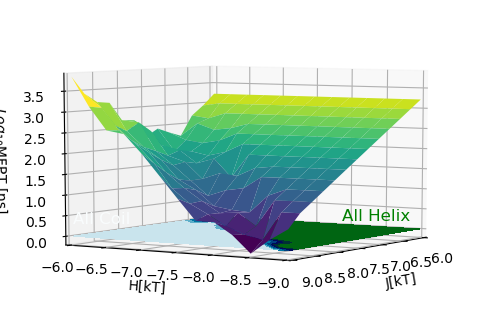

In [9]:
#Fig 2(a)
fig = plt.figure(dpi = 100)
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, np.log10(Z60)+9, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('J[kT]')
ax.set_ylabel('H[kT]')
ax.set_zlabel('$Log_{10}$MFPT [ns]');
ax.view_init(6, 33)
plt.xlim(6,9)
plt.ylim(-6,-9)


cset = ax.contourf(X, Y, H60, zdir='z', offset=np.min(Z60), cmap=cm.ocean)


ax.text(9, -6, 0.3, "All Coil", color=cm.ocean(0.99), fontsize = 12)
ax.text(6.5, -8.2,0.2, "All Helix", color=cm.ocean(0), fontsize = 12)



#plt.savefig("Fig2a.png", dpi = 500) 

plt.show()

Text(0, 0.5, 'H[kT]')

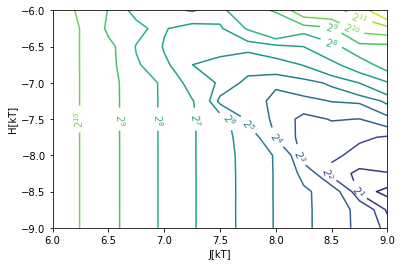

In [10]:
#Fig 2(b)
#Contour graph of MFPTs [ns]
fig2, ax2 = plt.subplots()

CS2 = ax2.contour(X, Y, Z60*10**9, locator=plt.LogLocator(base = 2, numticks = 15))
fmt = matplotlib.ticker.LogFormatterMathtext(base = 2)
fmt.create_dummy_axis()
ax2.clabel(CS2, CS2.levels, fmt=fmt)


plt.xlabel('J[kT]')
plt.ylabel('H[kT]')

#plt.show()

#plt.savefig('Fig2b.png', dpi = 500)

In [11]:
###Fig4:
critAlignment = 1


J_ax = np.linspace(6,9,7)
H_ax = np.linspace(-9,-6,7)

X, Y = np.meshgrid(J_ax, H_ax)

limit = 1350
chainLength = 21
numReps =10


Z_20C,H_20C = getSurf(J_ax, H_ax, limit, numReps, chainLength, helicity=1/21)
Z_2C,H_2C = getSurf(J_ax, H_ax, limit, numReps, chainLength, helicity=19/21)

Surface Complete!


Surface Complete!




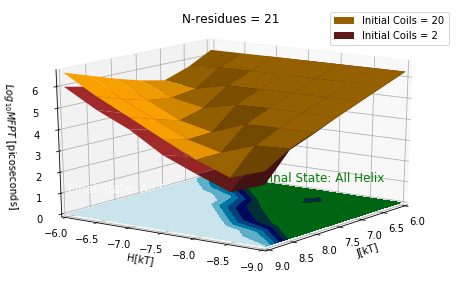

In [12]:
#Fig 4

fig = plt.figure(figsize = (8,5))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, np.log10(Z60), 50, cmap='binary')
S1 = ax.plot_surface(X, Y, np.log10(Z_20C)+12, rstride=1, cstride=1, color='orange', edgecolor='none', label='Initial Coils = 20')
S2 = ax.plot_surface(X, Y, np.log10(Z_2C)+12, rstride=1, cstride=1, color='brown', edgecolor='none', label='Initial Coils = 2')

#legends don't work for surfaces so we create edges to carry label
S1._facecolors2d=S1._facecolors3d
S1._edgecolors2d=S1._edgecolors3d

S2._facecolors2d=S2._facecolors3d
S2._edgecolors2d=S2._edgecolors3d

#ax.legend()

ax.set_xlabel('J[kT]')
ax.set_ylabel('H[kT]')
ax.set_zlabel("$Log_{10}MFPT$ [picoseconds]");
ax.view_init(18, 36)
plt.xlim(6,9)
plt.ylim(-6,-9)


#plotting bottom surf
#cset = ax.contourf(X, Y, H_2C, zdir='z', offset=np.min(Z60),cmap=cm.ocean)
cset = ax.contourf(X, Y, H_2C, zdir='z', offset=np.min(Z60)-0.01,cmap=cm.ocean)
ax.text(9, -6, 1, "Final State: All Coil", color=cm.ocean(0.99), fontsize = 12)
ax.text(6.5, -7.2,0.5, "Final State: All Helix", color=cm.ocean(0), fontsize = 12)


plt.title("N-residues = 21")
leg = plt.legend()

plt.show()

#plt.savefig('Fig4.png', dpi = 500)

In [13]:
#Fig 5(c)

#Analysis of impact on Initial chain configuration
#to the full helix configuration

critAlignment = 1

J = 7.5
H = -7.0

theta_c = np.linspace(0.0, 0.9, 10)
MFPTs10 = np.zeros(len(theta_c))
MFPTs20 = np.zeros(len(theta_c))
MFPTs40 = np.zeros(len(theta_c))
MFPTs60 = np.zeros(len(theta_c))

reps = 550
lim = 5150

for i in range(len(theta_c)):
    myChain10 = createChain(10, helicity = 1-float(theta_c[i]))
    MFPTs10[i] = MFPT(myChain10, J=J, H=H, limit = lim, numReps = reps)[0]
    
    
    myChain20 = createChain(20, helicity = 1-float(theta_c[i]))
    MFPTs20[i] = MFPT(myChain20, J=J, H=H, limit = lim, numReps = reps)[0]
    
    
    myChain40 = createChain(40, helicity = 1-float(theta_c[i]))
    MFPTs40[i] = MFPT(myChain40, J=J, H=H, limit = lim, numReps = reps)[0]
    
    
    myChain60 = createChain(60, helicity = 1-float(theta_c[i]))
    MFPTs60[i] = MFPT(myChain60, J=J, H=H, limit = lim, numReps = reps)[0]

    print("theta_c =", i, end=', ')
print("done!")

theta_c = 0, theta_c = 1, theta_c = 2, theta_c = 3, theta_c = 4, theta_c = 5, theta_c = 6, theta_c = 7, theta_c = 8, theta_c = 9, done!


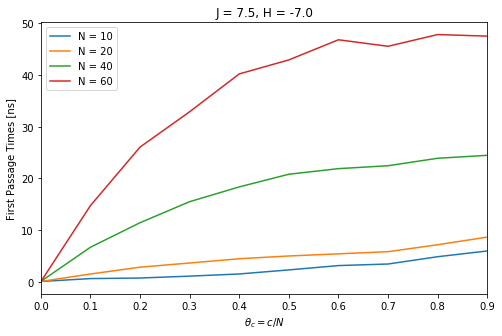

In [14]:
#Fig 5(c)

#Showing of dependance on initial chain configuration
fig, ax = plt.subplots(figsize=(8, 5))
#plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

plt.plot(theta_c, MFPTs10*10**9, label = "N = 10")
plt.plot(theta_c, MFPTs20*10**9, label = "N = 20")
plt.plot(theta_c, MFPTs40*10**9, label = "N = 40")
plt.plot(theta_c, MFPTs60*10**9, label = "N = 60")


#plt.ylim(0,1.2*np.max(MFPTs60))
plt.xlim(0,0.9)


plt.title("J = %.1f, H = %.1f" %(J,H))
plt.xlabel("$θ_c = c/N$")
plt.ylabel("First Passage Times [ns]")

leg = plt.legend()
#plt.savefig("Fig5c.png", dpi = 500) 




In [15]:
#Fig 6

critAlignment = 1

sigma = 0.002
s =1.5

J = -np.log(sigma)
H = np.log(s)-J

print("J = ", J)
print("H = ", H)

#chain lengths we want to study
minLength = 5
maxLength = 30


#chainLength = np.arange(minLength,maxLength+1)
chainLength = np.linspace(minLength,maxLength, 16)

#creating list for mean first passage times
mfpts = np.zeros(len(chainLength))

for i in range(len(chainLength)):
    
    print("chainLength = %.f" %chainLength[i], end = ',')
    
    #myChain=createRandChain(int(i),helicity = 0.0)
    myChain=createChain(int(chainLength[i]),helicity = 0.0)
    
    myFPTs = FPT_dist(myChain,J, H, limit=5750, numReps=1_000)[0]
    mfpts[i] = np.mean(myFPTs)
    
    

J =  6.214608098422191
H =  -5.809142990314027
chainLength = 5,chainLength = 7,chainLength = 8,chainLength = 10,chainLength = 12,chainLength = 13,chainLength = 15,chainLength = 17,chainLength = 18,chainLength = 20,chainLength = 22,chainLength = 23,chainLength = 25,chainLength = 27,chainLength = 28,chainLength = 30,

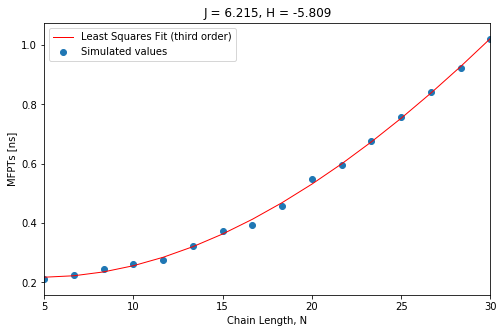

In [16]:
#Fig 6

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(chainLength, mfpts*10**9, label = 'Simulated values')


plt.xlabel("Chain Length, N")
plt.ylabel("MFPTs [ns]")
plt.xlim(5,np.max(chainLength))
plt.title("J = %.3f, H = %.3f" %(J,H))

z = np.polyfit(chainLength, mfpts*10**9, 3)
p = np.poly1d(z)
plt.plot(chainLength, p(chainLength), 'r-', linewidth = 1, label = 'Least Squares Fit (third order)')
plt.legend()


#plt.savefig("Fig6.png", dpi = 500) 

In [17]:
#Fig 8
#Analysis of impact on propagation parameter
#all coil to all helix configuration

critAlignment = 1

sigma = 0.002

#sigma = exp(-H) ==>H=-ln(sigma)
#s = exp(J+H)    ==> J+H = ln(s) => J = ln(s)-ln(sigma)
J = -np.log(sigma)
print("J = ", J, ",sigma = ", sigma)




s_const = np.array([0.05,0.3,0.4,0.55,0.7,1,1.5, 2, 3,4,5])
MFPTs10 = np.zeros(len(s_const))
MFPTs20 = np.zeros(len(s_const))
MFPTs40 = np.zeros(len(s_const))
MFPTs60 = np.zeros(len(s_const))

helicities60 = np.zeros(len(s_const))

reps = 50
lim = 1250

myChain10 = createChain(10, helicity = 0)
myChain20 = createChain(20, helicity = 0)
myChain40 = createChain(40, helicity = 0)
myChain60 = createChain(60, helicity = 0)

for i in range(len(s_const)):
    
    H = np.log(s_const[i])-J
    print("H = ", H,  end=', ')
    MFPTs10[i] = MFPT(myChain10.copy(), J, H, lim, reps)[0]
    MFPTs20[i] = MFPT(myChain20.copy(), J, H, lim, reps)[0]
    MFPTs40[i] = MFPT(myChain40.copy(), J, H, lim, reps)[0]
    MFPTs60[i], helicities60[i] = MFPT(myChain60.copy(), J, H, lim, reps)

    print("s_const =", i)



J =  6.214608098422191 ,sigma =  0.002
H =  -9.210340371976182, s_const = 0
H =  -7.418580902748127, s_const = 1
H =  -7.1308988302963465, s_const = 2
H =  -6.812445099177812, s_const = 3
H =  -6.571283042360924, s_const = 4
H =  -6.214608098422191, s_const = 5
H =  -5.809142990314027, s_const = 6
H =  -5.521460917862246, s_const = 7
H =  -5.115995809754081, s_const = 8
H =  -4.828313737302301, s_const = 9
H =  -4.605170185988091, s_const = 10


In [18]:
MFPTs60

array([7.49815375e-06, 2.07820835e-07, 1.16738760e-07, 6.14710181e-08,
       3.75102945e-08, 1.68267574e-08, 3.02677640e-09, 2.29930624e-09,
       3.00166924e-09, 3.99061421e-09, 5.45559488e-09])

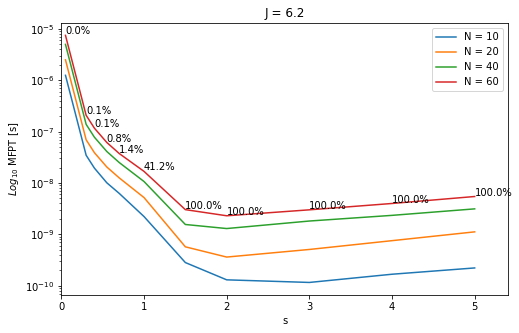

In [19]:
#Fig 8

#Showing of dependance on propagation parameter

#plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(s_const, MFPTs10, label = "N = 10")
plt.plot(s_const, MFPTs20, label = "N = 20")
plt.plot(s_const, MFPTs40, label = "N = 40")
plt.plot(s_const, MFPTs60, label = "N = 60")

#plt.text(s_const,MFPTs60,'testinmg')
#plt.text([0,1],[0,1],'testinmg')

for i,j,k in zip(s_const, MFPTs60*1.05, helicities60):
    plt.text(i,j,"%.1f%%" %(k*100))

    

plt.xlim(0,s_const[-1]+0.4)
plt.yscale('log')

plt.title("J = %.1f" %J)
plt.xlabel("s")
plt.ylabel("$Log_{10}$ MFPT [s]")

plt.legend()

#plt.savefig("Fig8.png", dpi = 300) 
